In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric,
    LGBM
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"

In [5]:
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

### Read Data

In [67]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg.pkl")
# train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_last.pkl")

Shape of data: (458913, 4294)
CPU times: user 3.17 s, sys: 9.25 s, total: 12.4 s
Wall time: 17.9 s


In [68]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


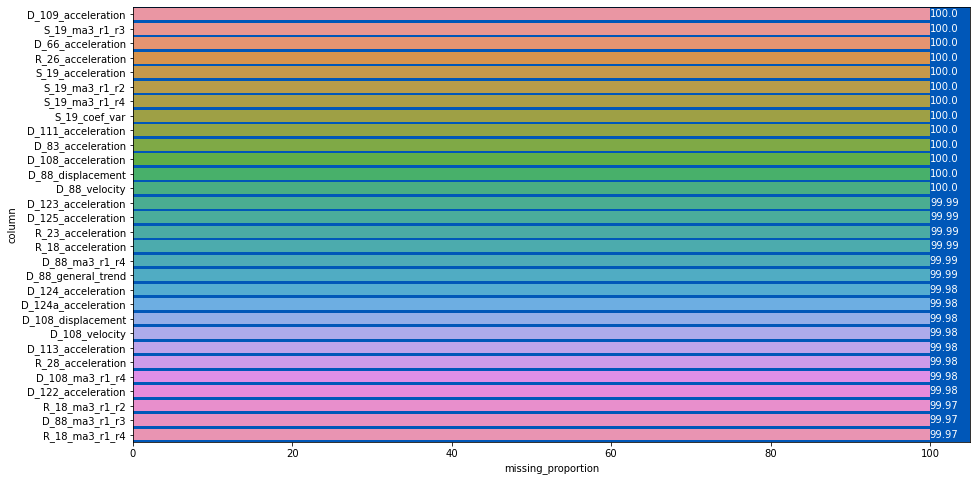

In [9]:
m = plot_missing_proportion_barchart(train_agg)

In [10]:
high_missing_columns = m.loc[m["missing_proportion"] > 95]["column"].tolist()
len(high_missing_columns)

459

In [11]:
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

In [12]:
train_agg.shape

(458913, 3835)

### Pre-train Feature Reduction

In [78]:
def select_noob_features(feature_imp_df, threshold):
    noob_features = []
    for type_ in feature_imp_df.columns[1:]:
        noob_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    print(len(noob_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return noob_features

In [79]:
def get_feature_imp_percentile(summary_df, p):
    array = pd.Series(np.stack(summary_df.drop(columns="base_feature", errors="ignore").values).ravel()).dropna().values
    return np.percentile(array, p)

In [106]:
features_to_drop = set()
for i, threshold_percentile in zip(range(5), range(5)):
    print(f"Read file {i}")
    summary_feature_imp = read_file(f"{EXP_PATH}/feature_imp_summary{i}.csv")
    # feature_imp_thr = get_feature_imp_percentile(summary_feature_imp, threshold_percentile)
    feature_imp_thr = 20
    drop_feature_subset = set(select_noob_features(summary_feature_imp, feature_imp_thr))
    features_to_drop = features_to_drop.union(drop_feature_subset)
    print(f"Threshold = {feature_imp_thr:.2f}, Dropping # of features {len(drop_feature_subset)}")

Read file 0
Shape of data: (181, 49)
1453 8688
Threshold = 20.00, Dropping # of features 1453
Read file 1
Shape of data: (176, 25)
815 4224
Threshold = 20.00, Dropping # of features 815
Read file 2
Shape of data: (188, 25)
1969 4512
Threshold = 20.00, Dropping # of features 1969
Read file 3
Shape of data: (163, 25)
1265 3912
Threshold = 20.00, Dropping # of features 1265
Read file 4
Shape of data: (140, 25)
557 3360
Threshold = 20.00, Dropping # of features 557


In [107]:
len(features_to_drop)

3940

In [108]:
%%time
train_agg = train_agg.drop(columns=list(features_to_drop), errors="ignore")
train_agg.shape

CPU times: user 199 ms, sys: 717 ms, total: 916 ms
Wall time: 1.02 s


(458913, 1596)

In [109]:
target = labels["target"].values

In [110]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 259 ms, sys: 417 ms, total: 676 ms
Wall time: 690 ms


36

In [111]:
cat_columns = train_agg.select_dtypes("category").columns.to_list()

In [112]:
train_agg.shape, target.shape

((458913, 1596), (458913,))

### Oversampling / Undersampling (SMOTE)

In [113]:
# sm = SMOTE(random_state=923)
# X_res, y_res = sm.fit_resample(train_agg, target)
# X_res.shape, y_res.shape

In [114]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=50)

In [115]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=40)

In [116]:
# train_analysis = single_col_target_check(train, "R_13", q=10)

In [117]:
# train_agg_analysis = single_col_target_check(train_agg, "S_6_last", q=10)

In [118]:
# train_agg_analysis.head()

In [119]:
# selected_features = pd.read_csv("top_features.csv")
# selected_features = selected_features["feature"].tolist()

In [120]:
# train_agg = train_agg.loc[:, selected_features]

In [121]:
# missing_count_df = plot_missing_proportion_barchart(train_agg)

In [122]:
# high_missing_columns = missing_count_df.loc[missing_count_df["missing_proportion"] > 75, "column"].tolist()

In [123]:
# print("Pre feature drop", train.shape)
# train_agg = train_agg.loc[:, set(feature_list).intersection(set(train_agg.columns))]
# train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")
# print("Post feature drop", train.shape)

### Tune LGBM using Optuna (KFold)

In [124]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_clean_agg_exp2"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_clean_agg_exp2'

In [125]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7958662214261033

In [127]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5) # , shuffle=True, random_state=1020
    params = {
        "objective": "binary",
        "metrics": "custom",
        "first_metric_only": True, 
        "boost_from_average": False,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "learning_rate": 0.025,
        "n_estimators": 1500,
        "max_bins": 127,
        "subsample_freq": 2,
        "min_child_samples": 1500,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 5, 30, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.65, 0.75),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.3, 2),
        "num_leaves": trial.suggest_int("num_leaves", 75, 120)
    }
    print(
        "alpha", round(params["reg_alpha"], 4), 
        "lambda", round(params["reg_lambda"], 4),
        "colsample_bytree", round(params["colsample_bytree"], 3),
        "subsample", round(params["subsample"], 3), 
        "scale_pos_weight", round(params["scale_pos_weight"], 3), 
        "num_leaves", round(params["num_leaves"], 0)
    )
    train_score_list, val_score_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        fold = str(fold)
        X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
        train_data = lgb.Dataset(
            X_train,
            y_train
        )
        X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
        valid_data = lgb.Dataset(
            X_val,
            y_val,
            reference=train_data
        )
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model = lgb.train(
                params=params,
                train_set=train_data, 
                valid_sets=[valid_data, train_data], 
                feval=lgb_amex_metric, 
                early_stopping_rounds=200,
                categorical_feature=cat_columns,
                callbacks=[
                    log_evaluation(100),
                ]
            )
        y_train_pred = model.predict(X_train, raw_score=True)
        train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
        train_data, X_train, y_train = None, None, None
        y_val_pred = model.predict(X_val, raw_score=True)
        val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
        valid_data, X_val, y_val = None, None, None
        train_score_list.append(train_score)
        val_score_list.append(val_score)
        if val_score > best_scores_json["validation"][fold]:
            best_scores_json["train"][fold] = train_score
            best_scores_json["validation"][fold] = val_score
            with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
                json.dump(best_scores_json, outfile)
            joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
        elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
            print(f"Train score too high (overfitting), start a new trial")
            return np.mean(val_score_list)
        print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
        print(f"Clear cache {gc.collect()}")
        
    return np.mean(val_score_list)

In [39]:
# study = joblib.load(f"{CURRENT_EXP_PATH}/optuna_study.pkl")

In [129]:
# study = optuna.create_study(direction="maximize")

[I 2022-07-29 03:43:35,484] A new study created in memory with name: no-name-f47c98f4-d772-41dd-9033-0954e5ba2b67


In [131]:
study.optimize(objective, n_trials=15)

alpha 0.0138 lambda 12.3481 colsample_bytree 0.219 subsample 0.702 scale_pos_weight 1.997 num_leaves 83
[100]	training's amex: 0.774296	valid_0's amex: 0.765286
[200]	training's amex: 0.794482	valid_0's amex: 0.781091
[300]	training's amex: 0.808839	valid_0's amex: 0.786989
[400]	training's amex: 0.819162	valid_0's amex: 0.789899
[500]	training's amex: 0.828097	valid_0's amex: 0.792065
[600]	training's amex: 0.837198	valid_0's amex: 0.792707
[700]	training's amex: 0.84618	valid_0's amex: 0.792814
[800]	training's amex: 0.85462	valid_0's amex: 0.793803
[900]	training's amex: 0.862656	valid_0's amex: 0.794439
[1000]	training's amex: 0.870538	valid_0's amex: 0.793926
[1100]	training's amex: 0.878487	valid_0's amex: 0.794234
Fold 1 | Train Score = 0.86477 (0.9575, 0.7721)
Fold 1 | Val Score = 0.79447 (0.9225, 0.6665)
Clear cache 34
[100]	training's amex: 0.773478	valid_0's amex: 0.763688
[200]	training's amex: 0.794735	valid_0's amex: 0.77874
[300]	training's amex: 0.808741	valid_0's amex:

[I 2022-07-29 12:32:31,178] Trial 15 finished with value: 0.795155459301177 and parameters: {'reg_alpha': 0.013794556691384505, 'reg_lambda': 12.348108964999765, 'colsample_bytree': 0.21915300554566775, 'subsample': 0.7021726570576217, 'scale_pos_weight': 1.9974732420451462, 'num_leaves': 83}. Best is trial 5 with value: 0.7955195888009693.


Clear cache 66
alpha 0.0288 lambda 9.8021 colsample_bytree 0.234 subsample 0.67 scale_pos_weight 1.746 num_leaves 99
[100]	training's amex: 0.77363	valid_0's amex: 0.765042
[200]	training's amex: 0.795402	valid_0's amex: 0.780078
[300]	training's amex: 0.81116	valid_0's amex: 0.787058
[400]	training's amex: 0.823229	valid_0's amex: 0.789382
[500]	training's amex: 0.833807	valid_0's amex: 0.791327
[600]	training's amex: 0.84452	valid_0's amex: 0.792292
[700]	training's amex: 0.854556	valid_0's amex: 0.793923
[800]	training's amex: 0.864625	valid_0's amex: 0.794386
[900]	training's amex: 0.874066	valid_0's amex: 0.794263
[1000]	training's amex: 0.883324	valid_0's amex: 0.795319
[1100]	training's amex: 0.892706	valid_0's amex: 0.79497
Fold 1 | Train Score = 0.88429 (0.9646, 0.8040)
Fold 1 | Val Score = 0.79552 (0.9228, 0.6682)
Clear cache 180
[100]	training's amex: 0.773312	valid_0's amex: 0.763534
[200]	training's amex: 0.795389	valid_0's amex: 0.778201
[300]	training's amex: 0.811228	va

[I 2022-07-29 13:03:23,825] Trial 16 finished with value: 0.7950223149106046 and parameters: {'reg_alpha': 0.02876226444143497, 'reg_lambda': 9.802143399783427, 'colsample_bytree': 0.2344642034435775, 'subsample': 0.6696975335831319, 'scale_pos_weight': 1.7457412322132513, 'num_leaves': 99}. Best is trial 5 with value: 0.7955195888009693.


Fold 5 | Train Score = 0.88546 (0.9648, 0.8061)
Fold 5 | Val Score = 0.79632 (0.9253, 0.6674)
Clear cache 250
alpha 0.0153 lambda 24.8305 colsample_bytree 0.234 subsample 0.698 scale_pos_weight 1.879 num_leaves 120
[100]	training's amex: 0.772162	valid_0's amex: 0.764519
[200]	training's amex: 0.794006	valid_0's amex: 0.77962
[300]	training's amex: 0.810571	valid_0's amex: 0.786059
[400]	training's amex: 0.824303	valid_0's amex: 0.789818
[500]	training's amex: 0.835672	valid_0's amex: 0.791534
[600]	training's amex: 0.846256	valid_0's amex: 0.79184
[700]	training's amex: 0.857111	valid_0's amex: 0.793031
[800]	training's amex: 0.867392	valid_0's amex: 0.793884
[900]	training's amex: 0.877094	valid_0's amex: 0.793366
Fold 1 | Train Score = 0.86883 (0.9588, 0.7789)
Fold 1 | Val Score = 0.79379 (0.9225, 0.6651)
Clear cache 174
[100]	training's amex: 0.773028	valid_0's amex: 0.761622
[200]	training's amex: 0.795079	valid_0's amex: 0.776767
[300]	training's amex: 0.811407	valid_0's amex: 0.

[I 2022-07-29 13:34:52,689] Trial 17 finished with value: 0.7947627289771713 and parameters: {'reg_alpha': 0.015336509719666208, 'reg_lambda': 24.830501842573213, 'colsample_bytree': 0.23384346301209671, 'subsample': 0.6983329351407987, 'scale_pos_weight': 1.8789410282114596, 'num_leaves': 120}. Best is trial 5 with value: 0.7955195888009693.


Fold 5 | Train Score = 0.88487 (0.9648, 0.8049)
Fold 5 | Val Score = 0.79637 (0.9252, 0.6675)
Clear cache 82
alpha 0.0452 lambda 17.9201 colsample_bytree 0.25 subsample 0.671 scale_pos_weight 1.796 num_leaves 99
[100]	training's amex: 0.773273	valid_0's amex: 0.765094
[200]	training's amex: 0.794267	valid_0's amex: 0.779853
[300]	training's amex: 0.810501	valid_0's amex: 0.78605
[400]	training's amex: 0.822257	valid_0's amex: 0.788956
[500]	training's amex: 0.83305	valid_0's amex: 0.790853
[600]	training's amex: 0.843217	valid_0's amex: 0.7924
[700]	training's amex: 0.853186	valid_0's amex: 0.793668
[800]	training's amex: 0.862472	valid_0's amex: 0.793953
[900]	training's amex: 0.872363	valid_0's amex: 0.794382
[1000]	training's amex: 0.881402	valid_0's amex: 0.793556



KeyboardInterrupt



### Train LGBM using previous hyper-params

In [72]:
%%time
lgbm_gbdt = LGBM(
    exp_full_path="../experiments/lgbm_gbdt_clean_agg_exp"
)
gbdt_master_feature_set = lgbm_gbdt.master_feature_set

CPU times: user 627 ms, sys: 367 ms, total: 994 ms
Wall time: 182 ms


In [73]:
hyperparams = [lgbm_gbdt.models[i].params for i in range(5)]

In [74]:
features = [lgbm_gbdt.models[i].feature_name() for i in range(5)]

In [75]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_clean_agg_exp2"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_clean_agg_exp2'

In [76]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7952671040871171

In [77]:
kf = StratifiedKFold(n_splits=5) # , shuffle=True, random_state=1020
train_score_list, val_score_list = [], []
for idx, fold, (idx_tr, idx_va) in zip(range(5), range(1, 5+1), kf.split(train_agg, target)):
    fold = str(fold)
    params_ = hyperparams[idx]
    feature_ = features[idx]
    X_train, y_train = train_agg.loc[idx_tr, feature_], target[idx_tr]
    train_data = lgb.Dataset(
        X_train,
        y_train
    )
    X_val, y_val = train_agg.loc[idx_va, feature_], target[idx_va], 
    valid_data = lgb.Dataset(
        X_val,
        y_val,
        reference=train_data
    )
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model = lgb.train(
            params=params_,
            train_set=train_data, 
            valid_sets=[valid_data, train_data], 
            feval=lgb_amex_metric, 
            early_stopping_rounds=200,
            callbacks=[
                log_evaluation(100),
            ]
        )
    y_train_pred = model.predict(X_train, raw_score=True)
    train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
    train_data, X_train, y_train = None, None, None
    y_val_pred = model.predict(X_val, raw_score=True)
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
    valid_data, X_val, y_val = None, None, None
    train_score_list.append(train_score)
    val_score_list.append(val_score)
    if val_score > best_scores_json["validation"][fold]:
        best_scores_json["train"][fold] = train_score
        best_scores_json["validation"][fold] = val_score
        with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
            json.dump(best_scores_json, outfile)
        joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
    elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
        print(f"Train score too high (overfitting), start a new trial")
    print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
    print(f"Clear cache {gc.collect()}")

[100]	training's amex: 0.772749	valid_0's amex: 0.764194
[200]	training's amex: 0.793912	valid_0's amex: 0.779027
[300]	training's amex: 0.809858	valid_0's amex: 0.786349
[400]	training's amex: 0.822633	valid_0's amex: 0.79024
[500]	training's amex: 0.833657	valid_0's amex: 0.792135
[600]	training's amex: 0.844581	valid_0's amex: 0.792309
[700]	training's amex: 0.855259	valid_0's amex: 0.793058
[800]	training's amex: 0.865281	valid_0's amex: 0.794597
[900]	training's amex: 0.875367	valid_0's amex: 0.794958
[1000]	training's amex: 0.884329	valid_0's amex: 0.795426
Fold 1 | Train Score = 0.87105 (0.9584, 0.7837)
Fold 1 | Val Score = 0.79562 (0.9229, 0.6683)
Clear cache 729
[100]	training's amex: 0.773301	valid_0's amex: 0.762565
[200]	training's amex: 0.793521	valid_0's amex: 0.776562
[300]	training's amex: 0.810059	valid_0's amex: 0.784916
[400]	training's amex: 0.822699	valid_0's amex: 0.789449
[500]	training's amex: 0.834109	valid_0's amex: 0.790836
[600]	training's amex: 0.844935	val

In [ ]:
# del train_agg, target

In [ ]:
del train_agg

In [41]:
study.best_trial

FrozenTrial(number=13, values=[0.7957243237457016], datetime_start=datetime.datetime(2022, 7, 23, 17, 10, 17, 948928), datetime_complete=datetime.datetime(2022, 7, 23, 17, 49, 22, 128688), params={'reg_alpha': 0.03419275048156644, 'reg_lambda': 10.13682796954036, 'colsample_bytree': 0.21796494267435756, 'subsample': 0.6247849970379308, 'scale_pos_weight': 1.9341486908332768, 'num_leaves': 83}, distributions={'reg_alpha': LogUniformDistribution(high=0.2, low=0.001), 'reg_lambda': LogUniformDistribution(high=50.0, low=10.0), 'colsample_bytree': UniformDistribution(high=0.3, low=0.19), 'subsample': UniformDistribution(high=0.75, low=0.5), 'scale_pos_weight': UniformDistribution(high=2.5, low=1.5), 'num_leaves': IntUniformDistribution(high=125, low=75, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE, value=None)

In [132]:
joblib.dump(study, f"{CURRENT_EXP_PATH}/optuna_study.pkl")

['../experiments/lgbm_gbdt_clean_agg_exp2/optuna_study.pkl']

In [133]:
study_df = study.trials_dataframe()

In [134]:
study_df = study_df.loc[study_df["state"] == "COMPLETE"]

In [135]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_num_leaves,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,state
0,0,0.795199,2022-07-29 03:43:37.134571,2022-07-29 04:15:38.718854,0 days 00:32:01.584283,0.211736,107,0.035459,19.665238,1.732579,0.718203,COMPLETE
1,1,0.794633,2022-07-29 04:15:38.720092,2022-07-29 04:51:31.726391,0 days 00:35:53.006299,0.240126,112,0.042724,8.493242,1.637483,0.683979,COMPLETE
2,2,0.795288,2022-07-29 04:51:31.727066,2022-07-29 05:00:37.160492,0 days 00:09:05.433426,0.242709,106,0.010279,7.959416,1.762319,0.738242,COMPLETE
3,3,0.795027,2022-07-29 05:00:37.170322,2022-07-29 05:35:14.543992,0 days 00:34:37.373670,0.246249,116,0.010454,5.280905,1.579482,0.718656,COMPLETE
4,4,0.795043,2022-07-29 05:35:14.545466,2022-07-29 06:10:02.834035,0 days 00:34:48.288569,0.209132,88,0.077343,15.609217,1.367447,0.716029,COMPLETE
5,5,0.795520,2022-07-29 06:10:02.835018,2022-07-29 06:46:57.128561,0 days 00:36:54.293543,0.237866,76,0.054068,14.030964,1.854585,0.671884,COMPLETE
6,6,0.795208,2022-07-29 06:46:57.129502,2022-07-29 07:19:31.398416,0 days 00:32:34.268914,0.234447,87,0.066375,6.484752,1.590657,0.674611,COMPLETE
7,7,0.794258,2022-07-29 07:19:31.399761,2022-07-29 07:28:16.288871,0 days 00:08:44.889110,0.200135,113,0.096341,6.831739,1.445638,0.718477,COMPLETE
8,8,0.794641,2022-07-29 07:28:16.298937,2022-07-29 07:37:16.176247,0 days 00:08:59.877310,0.239228,105,0.073812,10.654995,1.520339,0.737015,COMPLETE
9,9,0.794920,2022-07-29 07:37:16.179792,2022-07-29 08:08:40.770623,0 days 00:31:24.590831,0.205050,92,0.044620,26.370648,1.600485,0.732880,COMPLETE


In [136]:
study_df.to_csv(f"{CURRENT_EXP_PATH}/optuna_trials.csv", index=False)

In [ ]:
# read_file(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv')

In [ ]:
# study_df = study_df.drop(columns="number").reset_index(drop=True).reset_index().rename(columns={"index": "number"})

In [ ]:
# study_df.to_csv(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv', index=False)

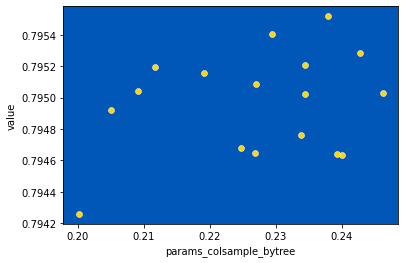

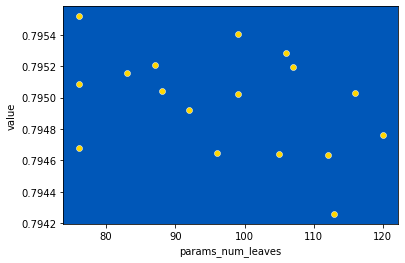

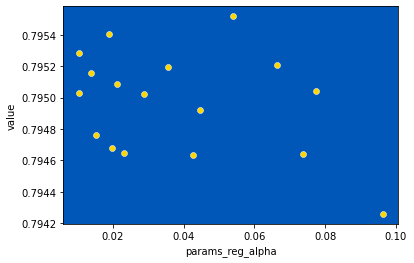

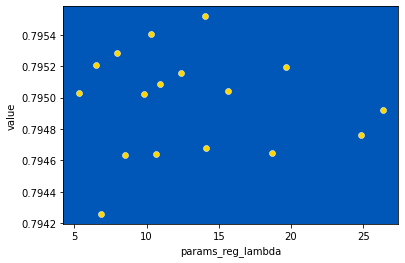

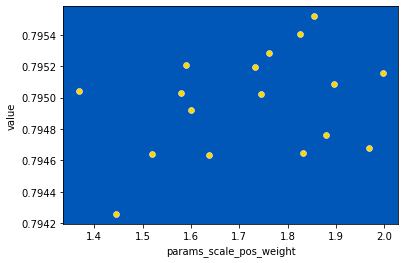

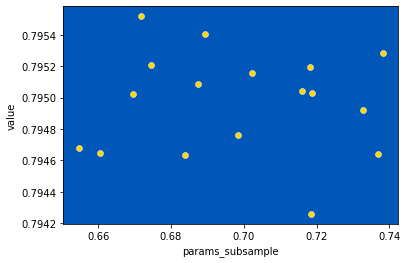

In [137]:
for col in get_cols(study_df, "params"):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"])
    plt.show()

In [ ]:
# study_df = study.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"].reset_index(drop=True)
# study_df.to_csv(f"{EXP_PATH}/lgbm_dart_exp/t.csv", index=False)

In [ ]:
np.mean(val_score_list)

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i, amex_metric_np(y_score_dict[i], y_val_dict[i]))

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

### Linear Analysis

In [ ]:
array = train_data.loc[train_data["customer_ID"] == train_data["customer_ID"][540]]["P_2"].astype("float32")

In [ ]:
np.polyfit(x=range(len(array)), y=array, deg=1)

In [ ]:
def calc_grad(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return gradient
    else:
        return 0

In [ ]:
def calc_intercept(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return y_intercept
    else:
        return array.values[0]

In [ ]:
temp = train.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                        P_2_intercept=("P_2", calc_intercept)).reset_index()
train_agg_summary = train_agg_summary.merge(temp, on="customer_ID", how="left")

In [ ]:
temp = test.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                       P_2_intercept=("P_2", calc_intercept)).reset_index()
test_agg_summary = test_agg_summary.merge(temp, on="customer_ID", how="left")

### Train Single LGBM

In [ ]:
kf = StratifiedKFold(n_splits=5)

In [ ]:
params = {
    'metrics': "custom",
    'first_metric_only': True, 
    'random_state': 1,
    'reg_alpha': 1, #0.0125, 
    'reg_lambda': 60, 
    'learning_rate': 0.1, 
    'n_estimators': 2000, 
    'colsample_bytree': 0.5, 
    'subsample': 0.7, 
    'subsample_freq': 5, 
    'min_child_samples': 2400, 
    'scale_pos_weight': 1.9, 
    'max_bins': 10, 
    'num_leaves': 50,
    'verbose': -1
}

In [ ]:
n_est_list = repeat(2000)

In [ ]:
# train_score_list, val_score_list = [], []
# for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
#     fold = str(fold)
#     X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
#     train_data = lgb.Dataset(
#         X_train,
#         y_train
#     )
#     X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
#     valid_data = lgb.Dataset(
#         X_val,
#         y_val,
#         reference=train_data
#     )
#     print("Start Training")
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore', category=UserWarning)
#         model = lgb.train(
#             params=params,
#             train_set=train_data, 
#             valid_sets=valid_data, 
#             feval=lgb_amex_metric, 
#             early_stopping_rounds=5,
#             categorical_feature=cat_columns,
#             callbacks=[
#                 log_evaluation(5),
#             ]
#         )
#     y_train_pred = model.predict(X_train, raw_score=True)
#     train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
#     X_train, y_train = None, None
#     y_val_pred = model.predict(X_val, raw_score=True)
#     val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
#     X_val, y_val = None, None
#     train_score_list.append(train_score)
#     val_score_list.append(val_score)
#     if val_score > best_scores_json["validation"][fold]:
#         print("Good")
#         # best_scores_json["train"][fold] = train_score
#         # best_scores_json["validation"][fold] = val_score
#         # with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
#         #     json.dump(best_scores_json, outfile)
#         # joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
#     elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.05:
#         print(f"Train score too high (overfitting), start a new trial")
#     print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
#     print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")

In [ ]:
np.mean(val_score_list)

In [ ]:
# imp_df = plot_feature_importance(model.feature_name_, model.feature_importances_, figsize=(16, 50), ascending=True, limit=300)

In [ ]:
imp_df.loc[imp_df["feature"] == "dummy"]

In [ ]:
zero_imp_features = sorted(imp_df.loc[imp_df["feature_importance"] == 0]["feature"].values.tolist())

In [ ]:
pd.Series(zero_imp_features, name="feature").to_csv(f"{DROP_FEATURES_PATH}/noob_features.csv", index=False)

In [ ]:
# train["target"] = target
# train.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp2/train_val.pkl")
# joblib.dump(train_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_train_scores.pkl')
# joblib.dump(val_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_scores.pkl')
# joblib.dump(val_idx_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_indices.pkl')

### Tune LGBM using Optuna (Single)

In [ ]:
def objective(trial):
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [1500, 1600, 1700, 1800, 1900, 2000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", np.arange(0.15, 0.4, 0.01)),
        "subsample": trial.suggest_categorical("subsample", np.arange(0.6, 0.8, 0.02)),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1, 2]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [2000, 2250, 2500]),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 450, log=True),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", np.arange(1.25, 2.5, 0.05)),
        "max_bins": trial.suggest_categorical("max_bins", np.arange(400, 550, 25)),
        "num_leaves": trial.suggest_categorical("num_leaves", np.arange(70, 180, 10)),
    }
    print(params)
    X_train, X_val, y_train, y_val = train_test_split(train_agg, target, test_size=0.2)
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            callbacks=[log_evaluation(200)]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score = amex_metric(y_train, y_train_pred)
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score = amex_metric(y_val, y_val_pred)
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
    return val_score

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials=5)